In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
from torchvision import models as mods
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
from sklearn.covariance import LedoitWolf, MinCovDet

from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score

np.random.seed(252525)
torch.manual_seed(252525)

import torch
import torch.nn as nn

from data.mvtec import *
from hugeica import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class FeatureExtractor(nn.Module):

    def __init__(self, network=None, pooling=4, p=6):
        super().__init__()
        #
        # Preparation
        #
        # Let's try to find the pooling layer positions
        if network is None:
            net = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True).features
            net = net.to(device)
            net.eval()

            self.idx_pooling_layer = []
            for i, module in enumerate( net.modules() ):
                if not isinstance(module, nn.Sequential):
                    if isinstance(module, nn.MaxPool2d):
                        self.idx_pooling_layer.append(i)
            self.F = self.idx_pooling_layer[pooling]

        #
        # The final net
        #
            self.features = net[:self.F]
        else:
            self.features = network
            
        self.shape = self.features(torch.normal(0,1, (1, 3, 224, 224)).to(device)).shape
        self.p = p

        self.mean = None # nn.Linear(self.shape[1], self.shape[1], bias=True).to(device)
        self.sphering = None #nn.Linear(self.shape[1], self.shape[1], bias=False).to(device)
        
        self.reset()
        
        # Sometimes inplace ReLUs cause problems with Laplace
        for module in self.features.modules():
            if not isinstance(module, nn.Sequential):
                if isinstance(module, nn.ReLU):
                    module.inplace = False

    def reset(self):
        pass
        #self.sphering.weight.data = torch.eye(self.shape[1]).to(device)
        #self.mean.weight.data = torch.eye(self.shape[1]).to(device)
        #self.mean.bias.data = torch.zeros(self.shape[1]).to(device)
    
    def forward(self, X):
        X = self.features(X)
        # X = X.mean((2,3)) # pooling the latents
        tiles = []
        for i in range(X.shape[2] - self.p + 1):
            for j in range(X.shape[2] - self.p + 1):
                xt = X[:, :, i:i+self.p, j:j+self.p]
                xt = xt.reshape(len(xt), -1)
                xt = xt - self.mean
                xt = xt @ self.sphering
                tiles.append(xt)
                
        return torch.stack(tiles)


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2000 must be less or equal to the batch number of samples 1225
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


AUC 0.9976190476190476


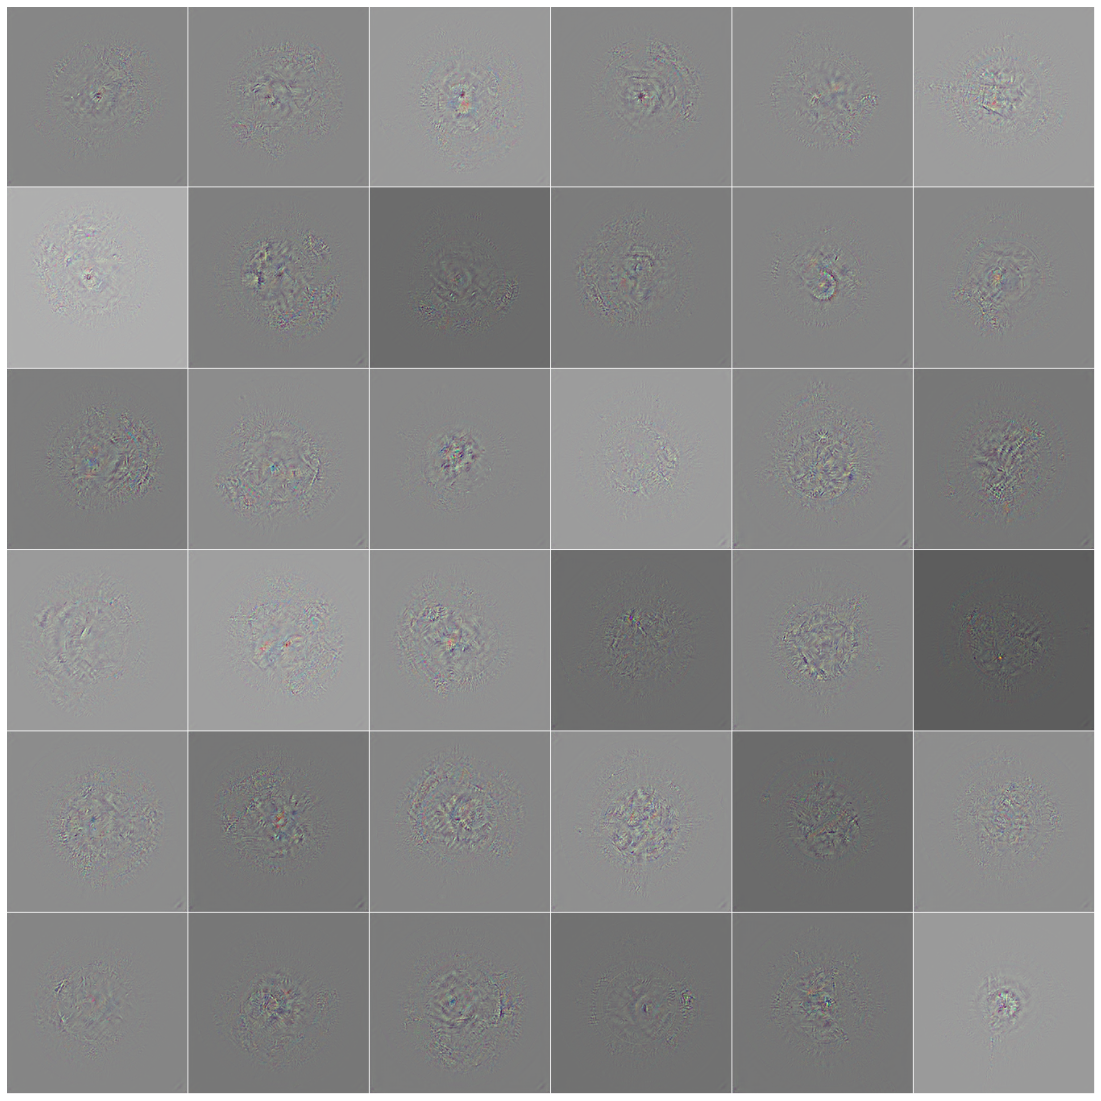

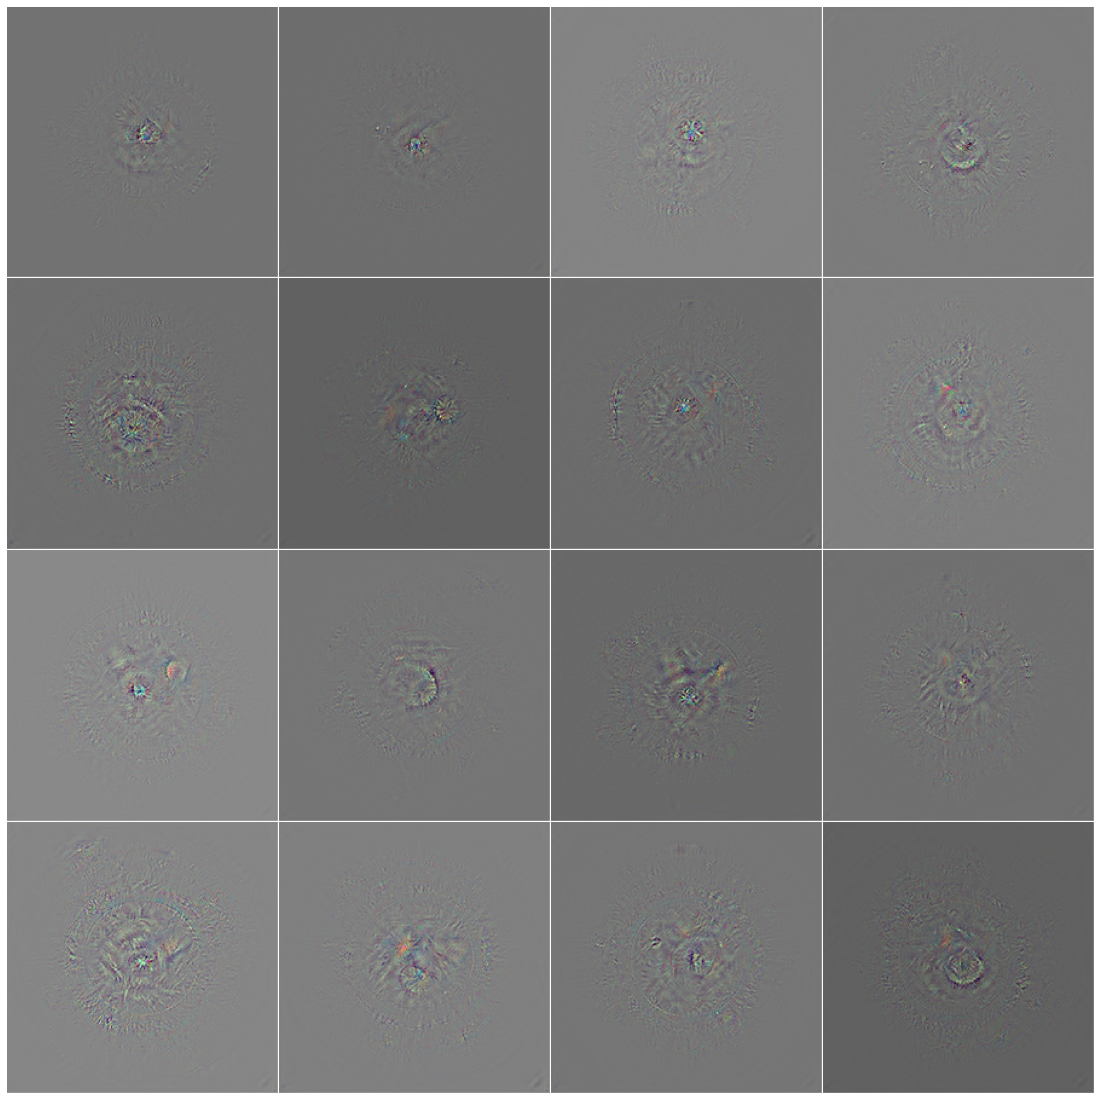

In [14]:
bs = 25
clazz = 0
epochs = 1
augment = False
layer = 6
p_size = 10
c = 160
t = 14
s = 1

#####################################################
#
# THE EXTRACTORS
#####################################################
net = mods.efficientnet_b4(pretrained=True).features[:6]
net = net.to(device)
net = net.eval()

extr = FeatureExtractor(net, p=p_size)
extr = extr.to(device)
extr.eval()


#####################################################
#
# LOAD THE DATA
#####################################################
X_, X_valid_, X_test_, X_labels_, T = zip(*[dataloader(clazz, P=224, s=224, label_per_patch=False, augment=augment) for i in range(epochs)])
X_, X_valid_, X_test_ = np.concatenate(X_), np.concatenate(X_valid_), np.concatenate(X_test_)

with torch.no_grad():
    X__ = torch.cat([ net(torch.from_numpy( X_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_), bs)]).cpu().numpy()
    X_valid__ = torch.cat([ net(torch.from_numpy( X_valid_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_valid_), bs)]).cpu().numpy()
    X_test__ = torch.cat([ net(torch.from_numpy( X_test_[i:i+bs] ).to(device) ).detach().cpu() for i in range(0, len(X_test_), bs)]).cpu().numpy()

#####################################################
#
# SPHERING FEATURE SPACE
#####################################################
model = SFA(shape=(c, t, t), 
                    BSZ=(p_size, p_size), 
                    stride=s, 
                    n_components="max",
                    remove_components=0,
                    max_components=5000,
                    min_components=100,
                    mode="ta")

model.fit(X__, 1, bs=2000, lr=1e-3, logging=-10)

S_in = model.transform(np.asarray(X_valid__), agg="mean")
S_out = model.transform(np.asarray(X_test__), agg="mean")

score_in = np.linalg.norm( S_in, axis=1)
score_out = np.linalg.norm(S_out, axis=1)
auc = roc_auc_score([0] * len(score_in) + [1] * len(score_out), np.concatenate([score_in, score_out]))
print("AUC", auc)

extr.mean = torch.from_numpy(model.model.mu[None, :]).to(device)
extr.sphering = torch.from_numpy(model.model.sphering_matrix).contiguous().to(device)

#####################################################
#
# Compute Input gradients
#####################################################
grads_test = []
for i in range(0, len(X_test__), 2):
    batch = torch.from_numpy( X_test_[i:i+2] ).to(device)
    batch.requires_grad = True

    s = extr( batch )
    s = torch.norm( s, dim=1 ).mean(0).mean()
    s.backward()
    grads_test.append(batch.grad.data.cpu().detach().clone())
grads_test = torch.cat(grads_test)

grads_valid = []
for i in range(0, len(X_valid_), 2):
    batch = torch.from_numpy( X_valid_[i:i+2] ).to(device)
    batch.requires_grad = True

    s = extr( batch )
    s = torch.norm( s, dim=1 ).mean(0).mean()
    s.backward()
    grads_valid.append(batch.grad.data.cpu().detach().clone())
grads_valid = torch.cat(grads_valid) 

#####################################################
#
# Make Grid
#####################################################
grads_test = grads_test.view(len(grads_test), -1)
grads_test = torch.abs(grads_test)
grads_test = grads_test - grads_test.min(1, keepdim=True)[0]
grads_test = grads_test / grads_test.max(1, keepdim=True)[0]

grads_valid = grads_valid.view(len(grads_valid), -1)
grads_valid = torch.abs(grads_valid)
grads_valid = grads_valid - grads_valid.min(1, keepdim=True)[0]
grads_valid = grads_valid / grads_valid.max(1, keepdim=True)[0]

plt.rcParams["figure.figsize"] = (20, 20)
show_filters_color(grads_test[:36].T, C=3)
plt.show()
show_filters_color(grads_valid[:36].T, C=3)
plt.show()